# Final Project - Transformer Implementation
**Authors**:
* Yuxuan Sun: <yuxuan_eric_sun@outlook.com>
* Sergey: <seriy.karp2@gmail.com>
* Haitao Gao: <haitaogao423@gmail.com>

**Code Repository**: <https://github.com/Erostrate9/needle>


## Introduction
To sum up what we learned during *10-714: Deep Learning Systems*, we've implemented the Transformer architecture and its corresponding modules with our self-made *needle*.

The overall goal of our *Final Project* is to implement the trainable Transformer architecture [1], which can be divided into some ingredients — Multi-Head Attention, Self-Attention and Positional Encoding, and The Transformer Architecture (Positionwise Feed-Forward Networks, Residual Connection and Layer Normalization, Transformer Encoder Block & Encoder, Transformer Decoder Block & Decoder, and Encoder-Decoder Seq2Seq model.)

In this project, in order to simplify the verification of numerical correctness, we use the implementation of d2l.ai [2] for reference, and its PyTorch implementation [3] has been cited for comparison.

[1]: Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is all you need." Advances in neural information processing systems 30, 2017.
[2]: Zhang, Aston, Zachary C. Lipton, Mu Li, and Alexander J. Smola. "Dive into deep learning." arXiv preprint arXiv:2106.11342, 2021.
[3]: Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J., “Releases v0.17.5 · D2L-ai/D2L-en-pytorch,” GitHub, 27-May-2022. [Online]. Available: <https://github.com/d2l-ai/d2l-en/releases/download/v0.17.5/d2l-en-pytorch.pdf>


In [1]:
# !pip3 install pybind11
# !pip install d2l==0.17.6

### Clone our needle repository.
# !git clone https://github.com/Erostrate9/needle
### Build ndarray backend. Export clang++ if necessary.
# !export CXX=/usr/bin/clang++ && make
# !make clean
# !make

### import required packages
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l

## Needle
We've implemented a fine needle with cpu/cuda ndarray backend.

In [156]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
import numpy as np

!python3 -m pytest -l -v -k "nd_backend"

============================= test session starts ==============================
platform linux -- Python 3.9.15, pytest-7.1.2, pluggy-1.0.0 -- /home/erostrate9/anaconda3/envs/dls/bin/python3
cachedir: .pytest_cache
rootdir: /home/erostrate9/PycharmProjects/needle
plugins: anyio-3.5.0
collected 1853 items / 1685 deselected / 168 selected                          

tests/test_nd_backend.py::test_ewise_fn[cpu-shape0-divide] PASSED        [  0%]
tests/test_nd_backend.py::test_ewise_fn[cpu-shape0-subtract] PASSED      [  1%]
tests/test_nd_backend.py::test_ewise_fn[cpu-shape1-divide] PASSED        [  1%]
tests/test_nd_backend.py::test_ewise_fn[cpu-shape1-subtract] PASSED      [  2%]
tests/test_nd_backend.py::test_ewise_fn[cuda-shape0-divide] PASSED       [  2%]
tests/test_nd_backend.py::test_ewise_fn[cuda-shape0-subtract] PASSED     [  3%]
tests/test_nd_backend.py::test_ewise_fn[cuda-shape1-divide] PASSED       [  4%]
tests/test_nd_backend.py::test_ewise_fn[cuda-shape1-subtract] PASSED     

## Multi-Head Attention
![Multi-head attention, where multiple heads are concatenated then linearly transformed.[2, Fig. 11.5.1]](https://d2l.ai/_images/multi-head-attention.svg)
### Model
As Prof. Zico Kolter has introduced the mechanism of self-attention and Transformer in Lecture 20 & 21, we'll briefly describe the theory part in this report and focus on its implementation.
According to [4], the practical implementation of attention normally used is what we called *multi-head attention*, which means that we run the self-attention mechanism of different subsets of the $K$, $Q$, $V$ terms, then concatenate them together.  Formally, we'll partition these terms as
\begin{equation}
K = \begin{bmatrix} K_1 & K_2 & \cdots & K_{\mathrm{heads}} \end{bmatrix}
\end{equation}
(and similarly for $Q$ and $V$.

Then will form the self attention outputs
\begin{equation}
Y_i = \mathrm{softmax}\left(\frac{K_iQ_i^T}{\sqrt{d/\mathrm{heads}}}\right)V_i
\end{equation}
and then form the final ouput
\begin{equation}
Y = \begin{bmatrix} Y_1 & Y_2 & \cdots & Y_{\mathrm{heads}} \end{bmatrix} W_o.
\end{equation}

[4]: Z. Kolter, “Public_notebooks/transformer_implementation.ipynb at main · dlsyscourse/public_notebooks,” Deep Learning Systems 21 - Transformers + Attention Implementation, 15-Nov-2022. [Online]. Available: https://github.com/dlsyscourse/public_notebooks/blob/main/transformer_implementation.ipynb.

### Implementation
#### masked_softmax
A softmax operation is used to output a probability distribution as attention weights. Sometimes, only some of the values should be fed into attention pooling. To get attention pooling over only meaningful tokens as values, we can specify a valid sequence length to filter out those beyond this range when computing softmax. In this way, we can implement such a masked softmax operation in the following masked_softmax function, where any value beyond the valid length is masked as zero.
```python
def masked_softmax(X, valid_lens):
    # valid_lens: numpy array
    def _sequence_mask(X: Tensor, valid_lens, value=0):
        # X: n * d
        maxlen = X.shape[-1]
        mask = (np.arange(maxlen)[None, :] < valid_lens[:, None])
        mask_mul = mask.astype(np.float32)
        mask_add = (~mask).astype(np.float32) * value
        mask_mul = Tensor(mask_mul, device=X.device, dtype=X.dtype, requires_grad=False)
        mask_add = Tensor(mask_add, device=X.device, dtype=X.dtype, requires_grad=False)
        return X * mask_mul + mask_add
    softmax = Softmax()
    if valid_lens is None:
        return softmax(X)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            assert valid_lens.shape[0] == X.shape[0]
            valid_lens = valid_lens.repeat(X.shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape((prod(shape[:-1]), shape[-1])), valid_lens, value=-1e6)
        return softmax(X.reshape(shape))
```




In [5]:
# Verification using d2l library [3]
# !pip install d2l==0.17.6
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l
# PyTorch implementation using d2l
_X = torch.rand(2, 2, 4)
_valid_lens = torch.tensor([2, 3])
_y = d2l.masked_softmax(_X, _valid_lens)
# Needle implementation with above input
device = ndl.cuda()
X = ndl.Tensor(_X.detach().numpy(), device=device)
valid_lens = _valid_lens.detach().numpy()
y = ndl.nn.masked_softmax(X, valid_lens)
assert np.linalg.norm(X.numpy() - _X.detach().numpy()) < 1e-5
assert np.linalg.norm(valid_lens - _valid_lens.detach().numpy()) < 1e-5
print("diff of masked_softmax: {0}".format(np.linalg.norm(y.numpy() - _y.detach().numpy())) )

# Similarly, we can also use a two-dimensional tensor to specify valid lengths for every row in each matrix example.
_X = torch.rand(2, 2, 4)
_valid_lens = torch.tensor([[1,3], [2, 4]])
_y = d2l.masked_softmax(_X, _valid_lens)
X = ndl.Tensor(_X.detach().numpy(), device=device)
valid_lens = _valid_lens.detach().numpy()
y = ndl.nn.masked_softmax(X, valid_lens)
assert np.linalg.norm(X.numpy() - _X.detach().numpy()) < 1e-5
assert np.linalg.norm(valid_lens - _valid_lens.detach().numpy()) < 1e-5
print("diff of masked_softmax: {0}".format(np.linalg.norm(y.numpy() - _y.detach().numpy())) )

diff of masked_softmax: 0.0
diff of masked_softmax: 4.470348358154297e-08


#### Scaled Dot-Product Attention
Scaled Dot-Product Attention is a computationally efficient design for attention scoring function, which requires that both the query and the key have the same vector length, denoted as $d$. Divide the dot product by $\sqrt{d}$ to ensure that the variance of it remains one regardless of vector length. With minibatches, the scaled dot-product attention of queries $\mathbf Q\in\mathbb R^{n\times d}$, keys $\mathbf K\in\mathbb R^{m\times d}$, and
values $\mathbf V\in\mathbb R^{m\times v}$ is $$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}$$
```python
class DotProductAttention(Module):
    """Scaled dot product attention."""

    def __init__(self, dropout):
        super().__init__()
        self.dropout = Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = ops.bmm(queries, keys.transpose((1, 2))) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return ops.bmm(self.dropout(self.attention_weights), values)
```

In [4]:
# The PyTorch implementation for verification using d2l.
_queries, _keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
_values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
2, 1, 1)
_valid_lens = torch.tensor([2, 6])
dropout = 0
_attention = d2l.DotProductAttention(dropout=dropout)
_attention.eval()
_y = _attention(_queries, _keys, _values, _valid_lens)

# Needle Implementation.
device = ndl.cpu()
queries = ndl.Tensor(_queries.detach().numpy(), device=device, dtype="float32")
keys = ndl.Tensor(_keys.detach().numpy(), device=device, dtype="float32")
values = ndl.Tensor(_values.detach().numpy(), device=device, dtype="float32")
valid_lens = _valid_lens.detach().numpy() if _valid_lens is not None else None

attention = ndl.nn.DotProductAttention(dropout=dropout)
attention.eval()
y = attention(queries, keys, values, valid_lens)

print("diff of DotProductAttention: {0}".format(np.linalg.norm(y.numpy() - _y.detach().numpy())) )

diff of DotProductAttention: 0.0



#### MultiHeadAttention
We use DotProductAttention as our attention scoring function. For each learnable parameter, its value is initialized by init.kaiming_uniform while PyTorch uses Xavier Initialization, hence the initial parameters of PyTorch and Needle implementation cannot be the same. To make a control group, before the computation, we simply copy the initial parameters of needle modules to their PyTorch counterparts.
```python
class MultiHeadAttention(Module):
    """Multi-head attention."""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, device=None, dtype="float32"):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = Linear(query_size, num_hiddens, bias=bias, device=device, dtype=dtype)
        self.W_k = Linear(key_size, num_hiddens, bias=bias, device=device, dtype=dtype)
        self.W_v = Linear(value_size, num_hiddens, bias=bias, device=device, dtype=dtype)
        self.W_o = Linear(num_hiddens, num_hiddens, bias=bias, device=device, dtype=dtype)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = valid_lens.repeat(repeats=self.num_heads, axis=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape((X.shape[0], X.shape[1], self.num_heads, -1))
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.permute((0, 2, 1, 3))
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.reshape((-1, X.shape[2], X.shape[3]))
        return X

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape((-1, self.num_heads, X.shape[1], X.shape[2]))
        X = X.permute((0, 2, 1, 3))
        return X.reshape((X.shape[0], X.shape[1], -1))
```

In [6]:
def set_attention(_attention, attention, use_bias=False):
    # _attention: d2l.MultiHeadAttention with PyTorch
    # attention: nn.MultiHeadAttention with Needle
    # multiHeadAttention_weight
    _attention.W_q.weight = torch.nn.Parameter(
        torch.tensor(attention.W_q.weight.numpy().T, dtype=torch.float32))
    _attention.W_k.weight = torch.nn.Parameter(
        torch.tensor(attention.W_k.weight.numpy().T, dtype=torch.float32))
    _attention.W_v.weight = torch.nn.Parameter(
        torch.tensor(attention.W_v.weight.numpy().T, dtype=torch.float32))
    _attention.W_o.weight = torch.nn.Parameter(
        torch.tensor(attention.W_o.weight.numpy().T, dtype=torch.float32))
    if use_bias:
        _attention.W_q.bias = torch.nn.Parameter(
            torch.tensor(attention.W_q.bias.numpy(), dtype=torch.float32))
        _attention.W_k.bias = torch.nn.Parameter(
            torch.tensor(attention.W_k.bias.numpy(), dtype=torch.float32))
        _attention.W_v.bias = torch.nn.Parameter(
            torch.tensor(attention.W_v.bias.numpy(), dtype=torch.float32))
        _attention.W_o.bias = torch.nn.Parameter(
            torch.tensor(attention.W_o.bias.numpy(), dtype=torch.float32))

num_hiddens, num_heads = 100, 5
batch_size, num_queries = 2, 4
num_kvpairs =  6
dropout = 0
_valid_lens = torch.tensor([3, 2])
device = ndl.cpu()
# valid_lens = None
_X = torch.randn((batch_size, num_queries, num_hiddens),dtype=torch.float32)
_Y = torch.randn((batch_size, num_kvpairs, num_hiddens),dtype=torch.float32)

_attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, dropout)
attention = ndl.nn.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                       num_hiddens, num_heads, dropout, device=device, dtype="float32")
valid_lens = _valid_lens.detach().numpy() if valid_lens is not None else None
X = ndl.Tensor(_X.detach().numpy(), device=ndl.cpu(), dtype="float32")
Y = ndl.Tensor(_Y.detach().numpy(), device=ndl.cpu(), dtype="float32")

set_attention(_attention, attention)
_attention.eval()
attention.eval()
_y = _attention(_X, _Y, _Y, _valid_lens)
y = attention(X, Y, Y, valid_lens)
print("diff of MultiHeadAttention: {0}".format(np.linalg.norm(_y.detach().numpy()-y.numpy())))

diff of MultiHeadAttention: 1.7648801076575182e-05


## Self-Attention and Positional Encoding
### Model
#### Self-Attention
According to [2], given a sequence of tokens as input: $\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^d$, its self-attention returns a sequence with the same length $\mathbf{y}_1, \ldots, \mathbf{y}_n$, where
$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$
In practice, we use above nn.MultiHeadAttention to compute the self-attention of a tensor with shape (batch size, number of time steps or sequence length in tokens, $d$).
#### Positional Encoding
Self-attention by itself does not preserve the order of the sequence. If the order of the input sequence matters, we'll added the positional encodings, which are additional inputs associated with each token, which represent information about the order of tokens. We now describe a simple scheme for fixed positional encodings based on sine and cosine functions [1].
Suppose that the input representation
$\mathbf{X} \in \mathbb{R}^{n \times d}$ contains the
$d$-dimensional embeddings for $n$ tokens of a sequence. The
positional encoding outputs $\mathbf{X} + \mathbf{P}$ using a
positional embedding matrix $\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape, whose element on the $i^\mathrm{th}$ row and the
$(2j)^\mathrm{th}$ or the $(2j + 1)^\mathrm{th}$ column is
$$p_{i, 2j} = \sin\left(\frac{i}{10000^{2j/d}}\right)$$
$$p_{i, 2j+1} = \cos\left(\frac{i}{10000^{2j/d}}\right)$$

### Implementation
```python
class PositionalEncoding(Module):
    """Positional encoding."""
    def                                 __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = Dropout(dropout)
        # Create a long enough P
        self.P = np.zeros((1, max_len, num_hiddens))
        p = np.arange(max_len).reshape(-1, 1) / np.power(
            10000, np.arange(0, num_hiddens, 2) / num_hiddens)
        self.P[:, :, 0::2] = np.sin(p)
        self.P[:, :, 1::2] = np.cos(p)

    def forward(self, X):
        P = Tensor(self.P[:, :X.shape[1], :], device=X.device, dtype=X.dtype, requires_grad=False)
        X = X + P.broadcast_to(X.shape)
        return self.dropout(X)
```
According to [2], in the positional embedding matrix, rows correspond to positions within a sequence and columns represent different positional encoding dimensions. In the example below, the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$ columns of the positional embedding matrix have a higher frequency than the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$ columns. The offset between the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$ (same for the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$) columns is due to the alternation of sine and cosine functions.

diff of pos_encoding: 5.306073489919072e-06


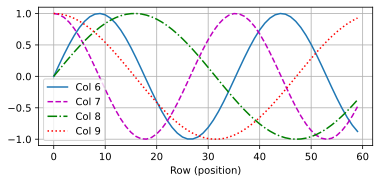

In [8]:
## PyTorch
encoding_dim, num_steps = 32, 60
_pos_encoding = d2l.PositionalEncoding(encoding_dim, 0)
_X = _pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
_P = _pos_encoding.P[:, :_X.shape[1], :]
d2l.plot(torch.arange(num_steps), _P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])
## Needle
device=ndl.cpu()
pos_encoding = ndl.nn.PositionalEncoding(encoding_dim, 0)
X =  ndl.Tensor(_X.detach().numpy(), device=device)

_output = _pos_encoding(_X)
output = pos_encoding(X)
print("diff of pos_encoding: {0}".format(np.linalg.norm(output.numpy() - _output.detach().numpy())))

## The Transformer Architecture
The whole implementation of the architecture is based on [1] and [2].
## Model
As a kind of encoder-decoder architecture, the overall structure of the Transformer is presented in the following figure.
![The Transformer architecture](https://d2l.ai/_images/transformer.svg)



## Reference
[1]: Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is all you need." Advances in neural information processing systems 30, 2017.
[2]: Zhang, Aston, Zachary C. Lipton, Mu Li, and Alexander J. Smola. "Dive into deep learning." arXiv preprint arXiv:2106.11342, 2021.
[3]: Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J., “Releases v0.17.5 · D2L-ai/D2L-en-pytorch,” GitHub, 27-May-2022. [Online]. Available: <https://github.com/d2l-ai/d2l-en/releases/download/v0.17.5/d2l-en-pytorch.pdf>
[4]: Z. Kolter, “Public_notebooks/transformer_implementation.ipynb at main · dlsyscourse/public_notebooks,” Deep Learning Systems 21 - Transformers + Attention Implementation, 15-Nov-2022. [Online]. Available: https://github.com/dlsyscourse/public_notebooks/blob/main/transformer_implementation.ipynb.
